# Online Retail Customer Segmentation

#### By utilizing SQL for ETL processes and visualization through matplotlib, this exercise aims to provide insights on consumer purchasing behaviour, analysis of key retail sales drivers and product performance relative to each other. 

In [1]:
# import libraries

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Online_Retail.csv")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,9/12/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,9/12/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,9/12/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,9/12/2011 12:50,4.15,12680.0,France


## Data-Preprocessing

In [3]:
#Handling duplicate rows
df=df.drop_duplicates()

#Removing Empty rows with missing customerID
df.dropna(subset=['CustomerID'], inplace=True)

# Check for NA values
na_values = df.isna()

# Sum of NA values in each column
na_values_sum = df.isna().sum()
print("\nSum of NA values in each column:\n", na_values_sum)

# Ensuring proper data type for variables
column_classes = df.dtypes

print("Class of each column:")
print(column_classes)


Sum of NA values in each column:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Class of each column:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


<ipython-input-3-2eb37cebf83b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['CustomerID'], inplace=True)


In [4]:
#I only want the sales data from the latest year - 2011
# Convert 'Date' column to datetime format
# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter rows for year 2011
df_2011 = df[df['InvoiceDate'].dt.year == 2011]

# Filter rows for year 2011 and include only positive values in Quantity
df_2011 = df_2011[(df_2011['InvoiceDate'].dt.year == 2011) & (df_2011['Quantity'] > 0)]

<ipython-input-4-c6020b123f78>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


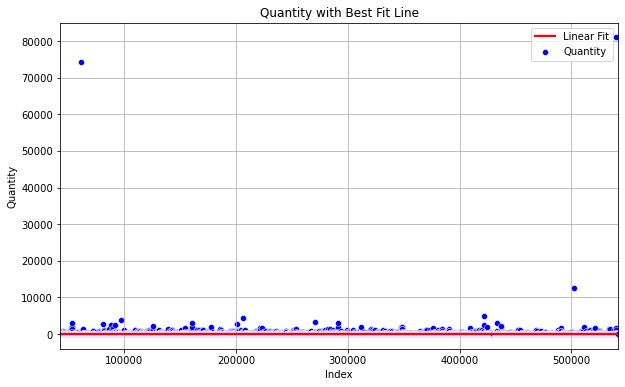

In [5]:
# Solving Outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_2011.index, y=df_2011['Quantity'], color='blue', label='Quantity')

# Fit and plot a linear regression line
sns.regplot(x=df_2011.index, y=df_2011['Quantity'], scatter=False, color='red', label='Linear Fit')

plt.title('Quantity with Best Fit Line')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
#Based on outlier analysis as well as business domain knowledge, we want to only analyse individual customers instead of whole sales buyers

df_2011= df_2011[df_2011['Quantity'] <= 1000]

### Connection to SQLite

In [7]:
#Connection to SQLite database
conn=sqlite3.connect('kai.db')
df_2011.to_sql('CS_Table',conn,if_exists='replace')

### What is the distribution of order values across all customers in 2011?

In [8]:
# Query the data from SQLite database
query = 'SELECT CustomerID, StockCode, Quantity FROM CS_Table ORDER BY Quantity DESC;'

order_distr = pd.read_sql(query, conn)

# Display the queried DataFrame
print("Purchase Distribution:")
print(order_distr)

Purchase Distribution:
        CustomerID StockCode  Quantity
0          16308.0     16014      1000
1          17553.0     62018      1000
2          17949.0     21497      1000
3          13848.0     16014      1000
4          17949.0     22197      1000
...            ...       ...       ...
366960     12748.0     22721         1
366961     12748.0     21351         1
366962     12748.0     22698         1
366963     12748.0     22567         1
366964     12748.0     37500         1

[366965 rows x 3 columns]


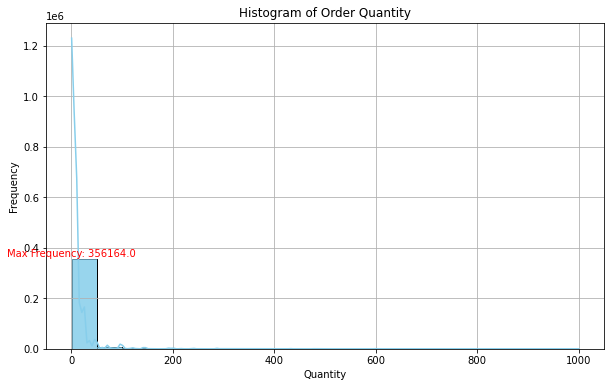

In [9]:
# Plotting using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.histplot(order_distr['Quantity'], bins=20, kde=True, color='skyblue')

# Find bin with highest frequency
counts, bins, _ = ax.hist(order_distr['Quantity'], bins=20, color='skyblue', alpha=0.7)
max_count_index = counts.argmax()
max_bin = bins[max_count_index]

# Annotate the bin with highest frequency
plt.text(max_bin, counts.max() + 1, f'Max Frequency: {counts.max()}',
         ha='center', va='bottom', fontsize=10, color='red')

# Adding labels and title
plt.title('Histogram of Order Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

plt.grid(True)
plt.show()

### How many unique products has each customer purchased in 2011?

In [10]:
query2 = 'SELECT CustomerID, COUNT(DISTINCT StockCode) AS UniqueProductsPurchased FROM CS_Table GROUP BY CustomerID ORDER BY UniqueProductsPurchased DESC;'
unq_prod = pd.read_sql(query2, conn)

# Display the queried DataFrame
print("Unique Products Purchased:")
print(unq_prod)

Unique Products Purchased:
      CustomerID  UniqueProductsPurchased
0        14911.0                     1746
1        12748.0                     1602
2        17841.0                     1293
3        14096.0                     1119
4        14298.0                      847
...          ...                      ...
4209     13068.0                        1
4210     13017.0                        1
4211     12908.0                        1
4212     12875.0                        1
4213     12823.0                        1

[4214 rows x 2 columns]


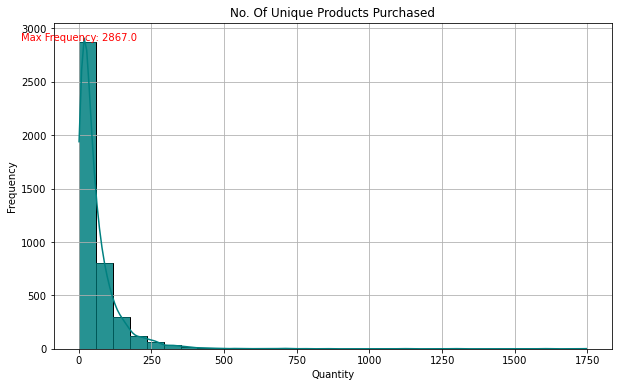

In [11]:
# Plotting using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.histplot(unq_prod['UniqueProductsPurchased'], bins=30, kde=True, color='teal')

# Find bin with highest frequency
counts, bins, _ = ax.hist(unq_prod['UniqueProductsPurchased'], bins=30, color='teal', alpha=0.7)
max_count_index = counts.argmax()
max_bin = bins[max_count_index]

# Annotate the bin with highest frequency
plt.text(max_bin, counts.max() + 1, f'Max Frequency: {counts.max()}',
         ha='center', va='bottom', fontsize=10, color='red')

# Adding labels and title
plt.title('No. Of Unique Products Purchased')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

plt.grid(True)
plt.show()

### Which customers have only made a single purchase from the company?

In [12]:
query3 = 'SELECT CustomerID, StockCode, COUNT(InvoiceNo) AS NoOfOrders FROM CS_Table GROUP BY CustomerID HAVING COUNT(InvoiceNo) = 1;'
single_pur = pd.read_sql(query3, conn)

# Display the queried DataFrame
print("Single Purchase:")
print(single_pur)

Single Purchase:
    CustomerID StockCode  NoOfOrders
0      12875.0     17096           1
1      13017.0     22112           1
2      13099.0     21422           1
3      13106.0     22456           1
4      13120.0     82482           1
..         ...       ...         ...
64     18087.0         M           1
65     18174.0    85099B           1
66     18184.0     15036           1
67     18233.0     22823           1
68     18268.0    84968A           1

[69 rows x 3 columns]


### Which products are most commonly purchased together?

In [13]:
query4='WITH ProductPairs AS (SELECT t1.StockCode AS Product1,t2.StockCode AS Product2,COUNT(*) AS Frequency FROM CS_Table t1 JOIN CS_Table t2 ON t1.InvoiceNo = t2.InvoiceNo AND t1.StockCode < t2.StockCode WHERE t1.StockCode != t2.StockCode GROUP BY t1.StockCode, t2.StockCode)SELECT Product1,Product2,Frequency FROM ProductPairs ORDER BY Frequency DESC LIMIT 10;'
prod_pairs = pd.read_sql(query4,conn)

# Display the queried DataFrame
print("Top 10 Product Pairs:")
print(prod_pairs)

Top 10 Product Pairs:
  Product1 Product2  Frequency
0    22386   85099B        551
1    22697    22699        532
2    20725    22384        524
3    20725    20727        521
4    20725    22383        515
5    22726    22727        489
6    23203   85099B        479
7    20727    22383        478
8    23300    23301        475
9    22697    22698        470


In [14]:
# Close the connection
conn.close()